In [36]:
from pypde import *
import matplotlib.pyplot as plt
from example import rbc2d
initplot()

def avg_x(f,dx):
    return np.sum(f*dx[:,None],axis=0)/np.sum(dx)


shape = (96,96)

Pr = 1
Ra = np.logspace(4,5,10)
Nu = []
for R in Ra:
    r = R/2**3
    nu = np.sqrt(Pr/r)
    kappa = np.sqrt(1/Pr/r)

    # -- Solve Navier Stokes
    NS = rbc2d.NavierStokes(shape=shape,dt=0.05,tsave=10.0,nu=nu,kappa=kappa,
    dealias=True,integrator="rk3",beta=1.0)

    NS.iterate(100.0)

    # -- Get Geometry
    x,y = NS.T.x,NS.T.y
    dx,dy = NS.T.dx, NS.T.dy
    xx,yy = np.meshgrid(x,y,indexing="ij")

    # -- Evaluate Nu
    T = NS.T.V[-1]

    Field = NS.deriv_field
    That = Field.forward(T)
    dThat = Field.derivative(That, 1, axis=1)
    dT = Field.backward(dThat)

    dTavg = avg_x(dT,Field.dx)
    Nu_bot = - dTavg[0]/0.5
    Nu_top = - dTavg[-1]/0.5
    print("Nubot: {:6.2f}".format(Nu_bot))
    print("Nutop: {:6.2f}".format(Nu_top))

    Nu.append(Nu_bot)

set color cycle ...
register goldfish colorbar as 'gfcmap' ...
update rc params to default ...
Initialize rk3 ...


/home/preiter/Python/pypde/pypde/plot/initplot.py:122: UserWarning: Trying to register the cmap 'gfcmap' which already exists.
  plt.cm.register_cmap(name='gfcmap', cmap=gfcmap())


Time: 10.000
Divergence: 1.98e-05
Time: 20.000
Divergence: 3.80e-05
Time: 30.000
Divergence: 3.73e-05
Time: 40.000
Divergence: 4.09e-05
Time: 50.000
Divergence: 4.40e-05
Time: 60.000
Divergence: 4.69e-05
Time: 70.000
Divergence: 4.95e-05
Time: 80.000
Divergence: 5.17e-05
Time: 90.000
Divergence: 5.34e-05
Time: 100.000
Divergence: 5.48e-05
Nubot:   1.16
Nutop:   1.16
Initialize rk3 ...
Time: 10.000
Divergence: 1.70e-05
Time: 20.000
Divergence: 4.10e-05
Time: 30.000
Divergence: 4.08e-05
Time: 40.000
Divergence: 4.60e-05
Time: 50.000
Divergence: 5.04e-05
Time: 60.000
Divergence: 5.42e-05
Time: 70.000
Divergence: 5.73e-05
Time: 80.000
Divergence: 5.98e-05
Time: 90.000
Divergence: 6.17e-05
Time: 100.000
Divergence: 6.31e-05
Nubot:   1.33
Nutop:   1.33
Initialize rk3 ...
Time: 10.000
Divergence: 1.43e-05
Time: 20.000
Divergence: 4.33e-05
Time: 30.000
Divergence: 4.53e-05
Time: 40.000
Divergence: 5.25e-05
Time: 50.000
Divergence: 5.82e-05
Time: 60.000
Divergence: 6.26e-05
Time: 70.000
Diverge

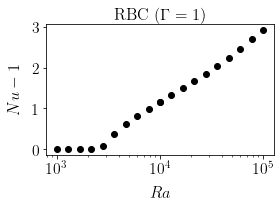

In [38]:
fig,ax = plt.subplots()
ax.scatter(Ra,Nu)
ax.set_xscale("log")
ax.set_ylabel(r"$Nu-1$")
ax.set_xlabel(r"$Ra$")
ax.set_title(r"RBC ($\Gamma=1$)")
fig.savefig("out/Nu.png")
plt.show()

/home/preiter/Python/pypde/pypde/plot/colors.py:25: UserWarning: Trying to register the cmap 'gfcmap' which already exists.
  plt.cm.register_cmap(name='gfcmap', cmap=gfcmap())


Save animation to out/anim.mp4


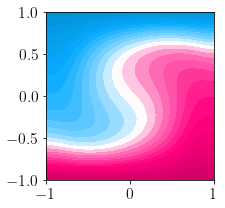

In [4]:
from IPython.display import HTML

#  Add inhomogeneous part
for i,v in enumerate(NS.T.V):
        if NS.T.V[i][0,0] < 0.1:
            NS.T.V[i] += NS.Tbc.v

anim = NS.T.animate(duration=4)
HTML(anim.to_jshtml())

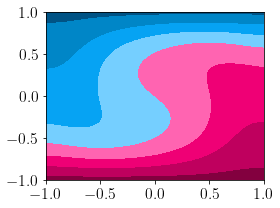

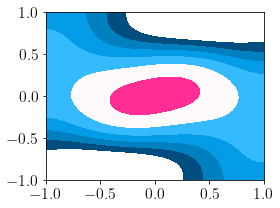

In [5]:
T = NS.T.V[-1]

Field = NS.deriv_field
That = Field.forward(T)
dThat = Field.derivative(That, 1, axis=1)
dT = Field.backward(dThat)

plt.contourf(xx,yy,T)
plt.show()
levels = np.linspace(-1,1,10)
plt.contourf(xx,yy,dT,levels=levels)
plt.show()

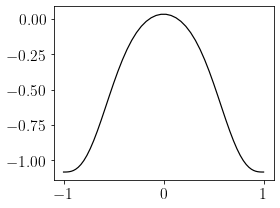

In [7]:
def avg_x(f,dx):
    return np.sum(f*dx[:,None],axis=0)/np.sum(dx)
dTavg = avg_x(dT,Field.dx)
plt.plot(y,dTavg)
plt.show()

In [13]:
Nu_bot = - dTavg[0]/0.5
Nu_top = - dTavg[-1]/0.5
print("Nubot: {:6.2f}".format(Nu_bot))
print("Nutop: {:6.2f}".format(Nu_top))

Nubot:   2.16
Nutop:   2.16


In [9]:
dTdz = grad(NS.T.field,deriv=(0,1),return_field=True)
dTdz.vhat += grad(NS.T.fieldbc,deriv=(0,1),return_field=False)
dTdz.backward()

NS.T.field.backward()
NS.V.field.backward()

uzT = NS.T.field.v*NS.V.field.v

Nu = 1/kappa*uzT - dTdz.v

xx,yy = np.meshgrid(NS.T.field.x,NS.T.field.y,indexing="ij")
plt.contourf(xx,yy,Nu)
plt.show()

plt.plot(NS.T.field.x, Nu[:,0])

AttributeError: 'Field' object has no attribute 'field'

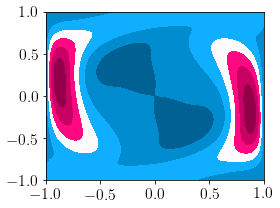

1.8486000909826696

In [137]:
Nu = np.zeros((NS.T.shape))
i=0

hist = []
for t,v in zip(NS.T.field.V,NS.V.field.V):    
    uzT = v*t
    dTdz = np.gradient(t,NS.T.field.y,axis=1)
    Nu = (Nu*i +  (uzT/kappa - dTdz))/(i+1)

    hist.append(np.sum(Nu[1:,0]*dx[:])/np.sum(dx))
    i+=1
    
#Nu = Nu/i
plt.contourf(xx,yy,Nu)
plt.show()

np.sum(Nu[1:,0]*dx[:])/np.sum(dx)

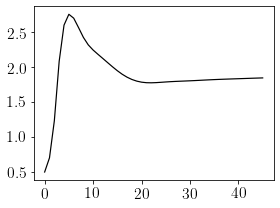

In [138]:
plt.plot(hist)

In [136]:
x = NS.T.field.x
dx = np.diff(x)
dx.shape

np.sum(Nu[1:,0]*dx[:])/np.sum(dx)

1.9444025248835684

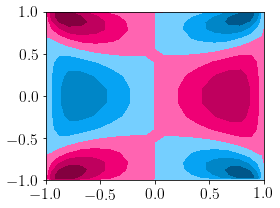

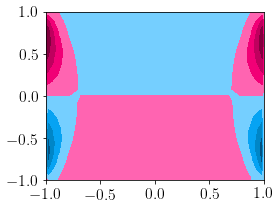

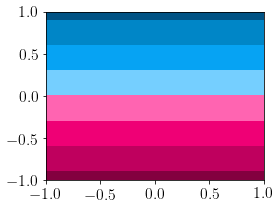

In [24]:
xx,yy = np.meshgrid(NS.T.field.x,NS.T.field.y,indexing="ij")

NS.V.field.backward()
NS.U.field.backward()
plt.contourf(xx,yy,NS.U.field.v)
plt.show()

plt.contourf(xx,yy,NS.V.field.v)
plt.show()

plt.contourf(xx,yy,NS.T.field.v)
plt.show()

In [2]:

xbase = Base(shape[0],"CN")
ybase = Base(shape[1],"CD")
    
T  = Temperature(shape=shape)
ux = Field([xbase,ybase])
uz = Field([xbase,ybase])

x,y = T.field.x, T.field.y
xx,yy = np.meshgrid(x,y,indexing="ij")

m,n = 1,1
ux.v =  2*np.cos(0.5*m*np.pi*xx)*np.sin(1.0*n*np.pi*yy)
uz.v = -2*np.sin(1.0*m*np.pi*xx)*np.cos(0.5*n*np.pi*yy)



In [3]:
#%%time
D = Temperature(shape=shape,dt=0.002,tsave=0.5,kappa=0.01)
D.iterate(5.0,ux_field = ux.v, uz_field=uz.v)

Time: 0.500
Time: 1.000
Time: 1.500
Time: 2.000
Time: 2.500
Time: 3.000
Time: 3.500
Time: 4.000
Time: 4.500
Time: 5.000
